In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../src')

# AT3 - Data Product with Machine Learning

## 3. Modeling

**[3.1]** Import the pandas and numpy package

In [3]:
import pandas as pd
import numpy as np

In [4]:
pd.set_option('display.max_columns', None)

**[3.2]** Load the Merge dataset into a dataframe called df

In [5]:
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_test = pd.read_parquet('../data/processed/X_test.parquet')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

### Baseline Model

**[3.3]** Import the NullRegressor class

In [6]:
from models.predict_model import NullRegressor

**[3.4]** Instantiate a NullRegressor and save it into a variable called base_model

In [7]:
base_model = NullRegressor()

**[3.5]** Make a prediction using fit_predict() and save the results in a variable called y_base

In [8]:
y_base = base_model.fit_predict(y_test)

**[3.6]** Import the function print_regressor_scores and display the RMSE and MAE scores of this baseline model on the testing set

In [9]:
from models.predict_model import print_regressor_scores

In [10]:
print_regressor_scores(y_preds=y_base, y_actuals=y_test, set_name='Testing')

RMSE Testing: 207.32320582921383
MAE Testing: 154.8408774410935


### Linear Regression Model

**[3.7]** Train Linear Regression Model

In [11]:
from sklearn.tree import DecisionTreeRegressor

**[3.8]** Instantiate the `LinearRegression` class

In [12]:
dt_regressor = DecisionTreeRegressor(random_state=42)

**[3.9]** Fit the model and display its performance on the training and validation sets

In [13]:
from models.predict_model import fit_assess_regressor

In [14]:
dt_regressor = fit_assess_regressor(dt_regressor, X_train, y_train, X_test, y_test)

RMSE Training: 187.86785383068693
MAE Training: 135.29078806338404
RMSE Testing: 201.59532371559197
MAE Testing: 146.12123783668255


**[4.0]** Display the permutations importance of all features

In [15]:
from models.predict_model import permutation_importance

/Users/narongvatchingpayakmon/at3_group_9/notebooks/../src/models/predict_model.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='feature', y='importance', palette='ch:.25')
/Users/narongvatchingpayakmon/at3_group_9/notebooks/../src/models/predict_model.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='feature', y='importance', palette='ch:.25')


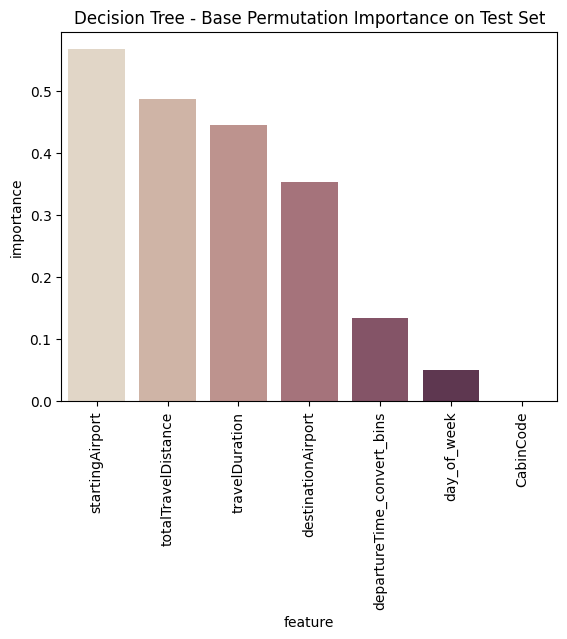

,feature,importance
0,startingAirport,0.566249
1,totalTravelDistance,0.486961
2,travelDuration,0.443924
3,destinationAirport,0.352779
4,departureTime_convert_bins,0.134634
5,day_of_week,0.050322
6,CabinCode,0.001255


In [18]:
permutation_importance(dt_regressor, X_test, y_test, 'Test', 'Decision Tree - Base')

### Hyperparameter tuning with Hyperopt

**[4.1]** Import Trials, STATUS_OK, tpe, hp, fmin from hyperopt package

In [19]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
rstate = np.random.default_rng(42)

In [20]:
space = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5)
}

In [21]:
def objective(space):
    from sklearn.model_selection import cross_val_score
    from math import sqrt

    regressor = DecisionTreeRegressor(max_depth=space['max_depth'],
                                    min_samples_split=space['min_samples_split'],
                                    min_samples_leaf=space['min_samples_leaf'])
    
    mse = cross_val_score(regressor, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = [-sqrt(abs(s)) for s in mse]
    avg_rmse = np.mean(rmse_scores)
    
    return {'loss': avg_rmse, 'status': STATUS_OK}

In [22]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    rstate=rstate,
)

100%|██████████| 100/100 [26:17<00:00, 15.78s/trial, best loss: -207.60609320958702]


In [23]:
print("Best parameters: ", best)

Best parameters:  {'max_depth': 4, 'min_samples_leaf': 0.4999589872264625, 'min_samples_split': 0.9773678301186622}


In [24]:
best_params = {
    'max_depth': best['max_depth'],
    'min_samples_leaf': best['min_samples_leaf'],
    'min_samples_split': best['min_samples_split']
}

In [25]:
dt_regressor_2 = DecisionTreeRegressor(**best_params)

In [26]:
dt_regressor_2 = fit_assess_regressor(dt_regressor_2, X_train, y_train, X_test, y_test)

RMSE Training: 207.6061323677396
MAE Training: 154.96751296354023
RMSE Testing: 207.32325943880164
MAE Testing: 154.85977866455676


In [28]:
from joblib import dump

In [29]:
dump(dt_regressor, '../models/dt_regressor.joblib')

['../models/dt_regressor.joblib']